In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pickle
import joblib as joblib
from joblib import dump, load
import seaborn as sns

In [22]:
data = pd.read_csv("prio_oct12_features.csv")

In [23]:
data = data.drop(['prop_critical_delay','speed', 'avg_total_hours_executed', 'consumer_evaluation', 'strikes', '% no negative wallet', 'avg_daily_utr', 'driver_delay_origin', 'orders', 'antiquity'], axis=1)

### Balancear Variables

In [24]:
# data.loc[data['speed']>=40,'speed']=data['speed'].mean()
# data.loc[data['avg_daily_utr']>3,'avg_daily_utr']=data['avg_daily_utr'].mean()
data.loc[data['avg recharge']>=((data['avg recharge'].std())*3),'avg recharge']=data['avg recharge'].mean()
# data.loc[data['prop_critical_delay']>=((data['prop_critical_delay'].std())*3), 'prop_critical_delay']=data['prop_critical_delay'].mean()
data.loc[data['qty recharge']>=((data['qty recharge'].std())*3),'qty recharge']=data['qty recharge'].mean()
data.loc[data['avg_daily_critical_hours_executed']>=((data['avg_daily_critical_hours_executed'].std())*3),'avg_daily_critical_hours_executed']=data['avg_daily_critical_hours_executed'].mean()
data.loc[data['avg_special_hours_executed']>=((data['avg_special_hours_executed'].std())*3),'avg_special_hours_executed']=data['avg_special_hours_executed'].mean()
# data.loc[data['avg_total_hours_executed']>=((data['avg_total_hours_executed'].std())*3),'avg_total_hours_executed']=data['avg_total_hours_executed'].mean()

In [25]:
df = data
df = df.drop_duplicates(['driver_uuid'])
city = df[['driver_uuid', 'logistic_region', 'date_partition']]
df = df.set_index(['driver_uuid'])

In [26]:
dict_scaler = {}

In [27]:
reducer = umap.UMAP(random_state=42,metric='cosine',
     min_dist=0.01, n_neighbors=9)

In [28]:
def process(data, dict_scaler, reducer): #output_data_path
    '''
    The function to execute the processing job.
    :param data: [pandas.DataFrame]
    :param model_path: [str], directory path to load your model(s)
    '''
    
    #dt = datetime.now().strftime('%Y%m%d')

    features = [
#                 'prop_critical_delay',
#                 'driver_delay_origin',
#                 'speed',
                'prop_completed_routes',
                'days_connected',
                'avg_daily_critical_hours_executed',
                'avg_special_hours_executed',
#                 'avg_total_hours_executed',
#                 'strikes',
                'qty recharge',
                'avg recharge',
#                 '% no negative wallet',
#                 'avg_daily_utr',
#                 'consumer_evaluation'
                ]

    regions = sorted(data['logistic_region'].unique())
    new_regions = [x for x in regions if x not in dict_scaler.keys()]

    if len(new_regions) > 0:

        for x in new_regions:
            print('Scaling data for regions:', new_regions)
            scaler = MinMaxScaler()
            Xf     = data[data['logistic_region'] == x][features].copy()
            dict_scaler[x] = scaler.fit(Xf)

        # dump(dict_scaler, os.path.join(model_path, 'dict_scaler_' + dt + '.pkl'))
    else:
        print('There is no new regions')

    # Scale data by region
    data_group  = data.groupby('logistic_region', as_index = False)
    data_scaled = []

    for i, gr in data_group:
        
        scaler = dict_scaler[i]
        gr_scaled = scaler.transform(gr[features])
        gr_scaled = pd.DataFrame(gr_scaled, columns = features, index = gr.index)
        data_scaled.append(gr_scaled)

    data_scaled = pd.concat(data_scaled)
    data_scaled = data_scaled.dropna()
#     data_scaled = df

    # reduce dimensionality
    data_reduced = reducer.fit_transform(data_scaled)
    data_reduced = pd.DataFrame(data_reduced, index = data_scaled.index)
    data_reduced.columns = ['c' + str(i) for i in range(1, data_reduced.shape[1] + 1)]

    # Saving files
    # print("Saving to {}".format(output_data_path))
    # data_scaled.to_parquet(os.path.join(output_data_path, 'data_scaled.parquet'))
    # data_reduced.to_parquet(os.path.join(output_data_path, 'data_reduced.parquet'))

    return data_reduced

In [29]:
data_reduced =  process(df, dict_scaler, reducer)

Scaling data for regions: ['Barranquilla', 'Bogota', 'Cali', 'Manizales', 'Medellin', 'Monteria', 'Palmira', 'Santa Marta', 'Soledad', 'Valledupar']
Scaling data for regions: ['Barranquilla', 'Bogota', 'Cali', 'Manizales', 'Medellin', 'Monteria', 'Palmira', 'Santa Marta', 'Soledad', 'Valledupar']
Scaling data for regions: ['Barranquilla', 'Bogota', 'Cali', 'Manizales', 'Medellin', 'Monteria', 'Palmira', 'Santa Marta', 'Soledad', 'Valledupar']
Scaling data for regions: ['Barranquilla', 'Bogota', 'Cali', 'Manizales', 'Medellin', 'Monteria', 'Palmira', 'Santa Marta', 'Soledad', 'Valledupar']
Scaling data for regions: ['Barranquilla', 'Bogota', 'Cali', 'Manizales', 'Medellin', 'Monteria', 'Palmira', 'Santa Marta', 'Soledad', 'Valledupar']
Scaling data for regions: ['Barranquilla', 'Bogota', 'Cali', 'Manizales', 'Medellin', 'Monteria', 'Palmira', 'Santa Marta', 'Soledad', 'Valledupar']
Scaling data for regions: ['Barranquilla', 'Bogota', 'Cali', 'Manizales', 'Medellin', 'Monteria', 'Palmira

In [30]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=20, random_state=42)
    kmeanModel.fit(data_reduced)
    distortions.append(kmeanModel.inertia_)

In [31]:
kmeanModel=KMeans(n_clusters=2,n_init=20, random_state=42)
clusterer = kmeanModel.fit(data_reduced)

In [32]:
pred = clusterer.predict(data_reduced)

In [33]:
response= {'driver_uuid': data_reduced.index, "segmentation": pred, "date_partition": df['date_partition']}
response = pd.DataFrame(response)
response['segmentation'] = response['segmentation'].astype(str)
response['segmentation'] = response['segmentation'].replace({'0': 'A',
		'1': 'B'})

In [34]:
response['segmentation'].value_counts()

A    2762
B    1532
Name: segmentation, dtype: int64

In [35]:
response.reset_index(drop = True, inplace = True)
df = pd.merge(data, response, on="driver_uuid")

In [36]:
df.groupby("segmentation").mean().T

segmentation,A,B
prop_completed_routes,0.566147,0.764145
days_connected,5.500181,8.308747
avg_daily_critical_hours_executed,0.993028,1.421651
avg_special_hours_executed,0.799146,1.341362
qty recharge,0.000362,1.434323
avg recharge,39.654228,41321.819647


In [37]:
    features = [
#                 'prop_critical_delay',
#                 'driver_delay_origin',
#                 'speed',
                'prop_completed_routes',
                'days_connected',
                'avg_daily_critical_hours_executed',
                'avg_special_hours_executed',
#                 'avg_total_hours_executed',
#                 'strikes',
                'qty recharge',
                'avg recharge',
#                 '% no negative wallet',
#                 'avg_daily_utr',
#                 'consumer_evaluation'
                ]

[0.04437896 0.05724565 0.0483209  0.03511216 0.20516477 0.60977756]


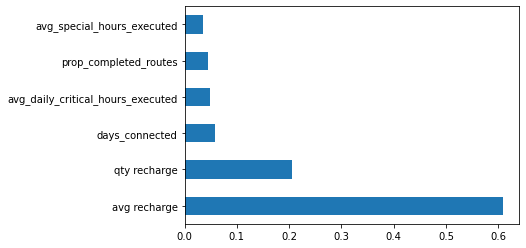

In [38]:
X = df[features] 
y = df['segmentation']  
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

<AxesSubplot:>

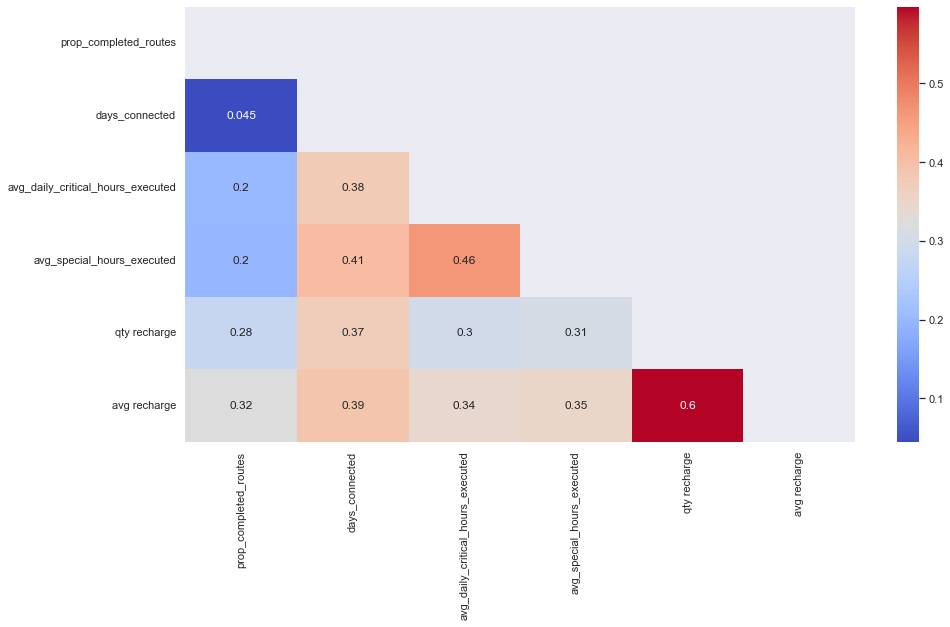

In [39]:
corr=df.corr()
mask=np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask)]=True
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr.abs(),annot=True,cmap="coolwarm",mask=mask)

### SUBSEGMENTATION A

In [40]:
data_A=df[df["segmentation"]=="A"]

In [41]:
df_A = data_A.set_index('driver_uuid')

In [42]:
data_reduced_A=process(df_A, dict_scaler, reducer)

There is no new regions


In [43]:
df_A

,logistic_region,prop_completed_routes,days_connected,avg_daily_critical_hours_executed,avg_special_hours_executed,qty recharge,avg recharge,date_partition_x,segmentation,date_partition_y
driver_uuid,,,,,,,,,,
0abbed50-7e0d-475a-b161-c2af444946ef,Bogota,0.678571,6,1.058750,2.540231,0.0,0.0,2022-10-11,A,2022-10-11
9d280512-97ef-4950-9ee7-4278b9b48902,Monteria,1.000000,1,1.307533,0.000000,0.0,0.0,2022-10-11,A,2022-10-11
029aa722-6241-4174-825f-c3689735ebd5,Barranquilla,1.000000,2,0.000000,0.000000,0.0,0.0,2022-10-11,A,2022-10-11
3e23da8c-f348-4bb6-a3ad-7d38b8768670,Barranquilla,0.873786,12,2.476458,1.329074,0.0,0.0,2022-10-11,A,2022-10-11
6f5eea49-ffd1-47c2-9481-edd97339130c,Bogota,1.000000,4,0.047153,0.013542,0.0,0.0,2022-10-11,A,2022-10-11
...,...,...,...,...,...,...,...,...,...,...
2c50dfde-d5fb-4376-b260-db22c71be60a,Bogota,0.442308,14,1.522063,1.533075,0.0,0.0,2022-10-11,A,2022-10-11
5cbbaca7-5318-4b7a-8ea8-ad20713a6fd9,Medellin,1.000000,2,0.791944,0.000000,0.0,0.0,2022-10-11,A,2022-10-11
820db4d3-f5a1-4e0d-8554-58367af8ccf5,Cali,1.000000,1,1.612500,0.000000,0.0,0.0,2022-10-11,A,2022-10-11


In [44]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=20, random_state=42)
    kmeanModel.fit(data_reduced_A)
    distortions.append(kmeanModel.inertia_)

In [45]:
kmeanModel=KMeans(n_clusters=2, n_init=20, random_state=42)
clusterer_A = kmeanModel.fit(data_reduced_A)

In [46]:
pred = clusterer_A.predict(data_reduced_A)

In [47]:
response_A= {'driver_uuid': data_reduced_A.index, "subsegmentation": pred, "date_partition": df_A['date_partition_x']}
response_A = pd.DataFrame(response_A)
response_A['subsegmentation'] = response_A['subsegmentation'].astype(str)
response_A['subsegmentation'] = response_A['subsegmentation'].replace({'0': 'AA',
		'1': 'AB'})

In [48]:
response_A['subsegmentation'].value_counts()

AA    1506
AB    1259
Name: subsegmentation, dtype: int64

In [49]:
response_A.reset_index(drop = True, inplace = True)
df_A = pd.merge(df_A, response_A, on="driver_uuid")

In [50]:
df_A.groupby("subsegmentation").mean().T

subsegmentation,AA,AB
prop_completed_routes,0.422519,0.736825
days_connected,7.607427,2.973872
avg_daily_critical_hours_executed,1.111064,0.848097
avg_special_hours_executed,0.893785,0.685777
qty recharge,0.000000,0.000792
avg recharge,29.754190,51.286319


### SUBSEGMENTATION B

In [51]:
data_B=df[df["segmentation"]=="B"]

In [52]:
df_B = data_B.set_index('driver_uuid')

In [53]:
# data_reduced1 = process(df_B, dict_scaler, reducer)

data_reduced_B=process(df_B, dict_scaler, reducer)

There is no new regions


In [54]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=20, random_state=42)
    kmeanModel.fit(data_reduced_B)
    distortions.append(kmeanModel.inertia_)

C:\Users\daniel.gallo_ifood\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [55]:
kmeanModel=KMeans(n_clusters=4, n_init=20, random_state=42)
clusterer_B = kmeanModel.fit(data_reduced_B)

In [56]:
pred = clusterer_B.predict(data_reduced_B)

In [57]:
response_B= {'driver_uuid': data_reduced_B.index, "subsegmentation": pred, "date_partition": df_B['date_partition_x']}
response_B = pd.DataFrame(response_B)
response_B['subsegmentation'] = response_B['subsegmentation'].astype(str)
response_B['subsegmentation'] = response_B['subsegmentation'].replace({'0': 'BA',
		'1': 'BB', '2':'BC', '3':'BD'})

In [58]:
response_B['subsegmentation'].value_counts()

BD    538
BB    477
BA    452
BC     65
Name: subsegmentation, dtype: int64

In [61]:
response_B.reset_index(drop = True, inplace = True)
df_B = pd.merge(df_B, response_B, on="driver_uuid")

In [62]:
df_B.groupby("subsegmentation").mean().T

subsegmentation,BA,BB,BC,BD
prop_completed_routes,0.775542,0.807161,0.767137,0.716069
days_connected,4.115044,10.268344,1.015385,10.975836
avg_daily_critical_hours_executed,1.160296,1.688735,0.002889,1.575838
avg_special_hours_executed,0.707170,1.974821,0.001722,1.474395
qty recharge,0.681744,3.225076,0.000000,0.652181
avg recharge,41928.111251,45369.455582,0.000000,42216.154462


In [63]:
pd.DataFrame(df.skew(axis=0))

C:\Users\DANIEL~1.GAL\AppData\Local\Temp/ipykernel_18408/4008468014.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.DataFrame(df.skew(axis=0))


,0
prop_completed_routes,-0.313033
days_connected,0.344587
avg_daily_critical_hours_executed,0.348286
avg_special_hours_executed,0.846671
qty recharge,2.723995
avg recharge,1.300910


In [64]:
df_final = df_A.append(df_B,ignore_index=True)

In [65]:
df_final.to_excel(r'C:\Users\daniel.gallo_ifood\Desktop\Daniel\Prioritization\prioritization_first.xlsx', index = False)

In [66]:
df_final['subsegmentation'].value_counts()

AA    1508
AB    1263
BD     538
BB     477
BA     452
BC      65
Name: subsegmentation, dtype: int64

In [67]:
df_final.groupby("subsegmentation").mean().T

subsegmentation,AA,AB,BA,BB,BC,BD
prop_completed_routes,0.422519,0.736825,0.775542,0.807161,0.767137,0.716069
days_connected,7.607427,2.973872,4.115044,10.268344,1.015385,10.975836
avg_daily_critical_hours_executed,1.111064,0.848097,1.160296,1.688735,0.002889,1.575838
avg_special_hours_executed,0.893785,0.685777,0.707170,1.974821,0.001722,1.474395
qty recharge,0.000000,0.000792,0.681744,3.225076,0.000000,0.652181
avg recharge,29.754190,51.286319,41928.111251,45369.455582,0.000000,42216.154462


In [68]:
# 1 AA
# 2 BC + Nuevos (+reactivadosbuenos)
# 3 BA
# 4 BD + Reactivados malos
# 5 BB
# 6 AB


In [69]:
data = pd.read_csv("prio_oct12_features.csv")

In [70]:
data = data.drop(['prop_critical_delay','speed', 'avg_total_hours_executed', 'consumer_evaluation', 'strikes', '% no negative wallet', 'avg_daily_utr', 'driver_delay_origin', 'orders', 'antiquity'], axis=1)

In [71]:
# data.loc[data['speed']>=40,'speed']=data['speed'].mean()
# data.loc[data['avg_daily_utr']>3,'avg_daily_utr']=data['avg_daily_utr'].mean()
data.loc[data['avg recharge']>=((data['avg recharge'].std())*3),'avg recharge']=data['avg recharge'].mean()
# data.loc[data['prop_critical_delay']>=((data['prop_critical_delay'].std())*3), 'prop_critical_delay']=data['prop_critical_delay'].mean()
data.loc[data['qty recharge']>=((data['qty recharge'].std())*3),'qty recharge']=data['qty recharge'].mean()
data.loc[data['avg_daily_critical_hours_executed']>=((data['avg_daily_critical_hours_executed'].std())*3),'avg_daily_critical_hours_executed']=data['avg_daily_critical_hours_executed'].mean()
data.loc[data['avg_special_hours_executed']>=((data['avg_special_hours_executed'].std())*3),'avg_special_hours_executed']=data['avg_special_hours_executed'].mean()
# data.loc[data['avg_total_hours_executed']>=((data['avg_total_hours_executed'].std())*3),'avg_total_hours_executed']=data['avg_total_hours_executed'].mean()

In [73]:
df = data
df = df.drop_duplicates(['driver_uuid'])
city = df[['driver_uuid', 'logistic_region', 'date_partition']]
df = df.set_index(['driver_uuid'])

In [74]:
# dict_scaler = {}
# reducer = umap.UMAP(random_state=42)

In [75]:
data_reduced =  process(df, dict_scaler, reducer)

There is no new regions


In [76]:
pred = clusterer.predict(data_reduced)

In [77]:
clusterer

KMeans(n_clusters=2, n_init=20, random_state=42)

In [78]:
response= {'driver_uuid': data_reduced.index, "segmentation": pred, "date_partition": df['date_partition']}
response = pd.DataFrame(response)
response['segmentation'] = response['segmentation'].astype(str)
response['segmentation'] = response['segmentation'].replace({'0': 'A',
		'1': 'B'})

In [79]:
response['segmentation'].value_counts()

A    2762
B    1532
Name: segmentation, dtype: int64

In [80]:
response.reset_index(drop = True, inplace = True)
df = pd.merge(data, response, on="driver_uuid")

In [81]:
df.groupby("segmentation").mean().T

segmentation,A,B
prop_completed_routes,0.566147,0.764145
days_connected,5.500181,8.308747
avg_daily_critical_hours_executed,0.993028,1.421651
avg_special_hours_executed,0.799146,1.341362
qty recharge,0.000362,1.434323
avg recharge,39.654228,41321.819647


In [82]:
data_A=df[df["segmentation"]=="A"]

In [83]:
df_A = data_A.set_index('driver_uuid')

In [84]:
data_reduced_A=process(df_A, dict_scaler, reducer)

There is no new regions


In [85]:
pred = clusterer_A.predict(data_reduced_A)

In [86]:
response_A= {'driver_uuid' : data_reduced_A.index, "subsegmentation": pred, "date_partition": df_A['date_partition_x']}
response_A = pd.DataFrame(response_A)
response_A['subsegmentation'] = response_A['subsegmentation'].astype(str)
response_A['subsegmentation'] = response_A['subsegmentation'].replace({'0': 'AA',
		'1': 'AB',
		'2': 'AC'})

In [87]:
response_A.reset_index(drop = True, inplace = True)
df_A = pd.merge(df_A, response_A, on="driver_uuid")

In [88]:
response_A['subsegmentation'].value_counts()

AA    1506
AB    1259
Name: subsegmentation, dtype: int64

In [89]:
df_A.groupby("subsegmentation").mean().T

subsegmentation,AA,AB
prop_completed_routes,0.422519,0.736825
days_connected,7.607427,2.973872
avg_daily_critical_hours_executed,1.111064,0.848097
avg_special_hours_executed,0.893785,0.685777
qty recharge,0.000000,0.000792
avg recharge,29.754190,51.286319


In [90]:
data_B=df[df["segmentation"]=="B"]

In [91]:
df_B = data_B.set_index('driver_uuid')

In [92]:
data_reduced_B=process(df_B, dict_scaler, reducer)

There is no new regions


In [93]:
pred = clusterer_B.predict(data_reduced_B)

In [94]:
response_B= {'driver_uuid': data_reduced_B.index, "subsegmentation": pred, "date_partition": df_B['date_partition_x']}
response_B = pd.DataFrame(response_B)
response_B['subsegmentation'] = response_B['subsegmentation'].astype(str)
response_B['subsegmentation'] = response_B['subsegmentation'].replace({'0': 'BA',
		'1': 'BB',
		'2': 'BC',
		'3': 'BD'})

In [95]:
response_B.reset_index(drop = True, inplace = True)
df_B = pd.merge(df_B, response_B, on="driver_uuid")

In [96]:
response_B['subsegmentation'].value_counts()

BD    538
BB    477
BA    452
BC     65
Name: subsegmentation, dtype: int64

In [97]:
df_B.groupby("subsegmentation").mean().T

subsegmentation,BA,BB,BC,BD
prop_completed_routes,0.775542,0.807161,0.767137,0.716069
days_connected,4.115044,10.268344,1.015385,10.975836
avg_daily_critical_hours_executed,1.160296,1.688735,0.002889,1.575838
avg_special_hours_executed,0.707170,1.974821,0.001722,1.474395
qty recharge,0.681744,3.225076,0.000000,0.652181
avg recharge,41928.111251,45369.455582,0.000000,42216.154462


In [98]:
df_final = df_A.append(df_B,ignore_index=True)

In [99]:
df_final.groupby("subsegmentation").mean().T

subsegmentation,AA,AB,BA,BB,BC,BD
prop_completed_routes,0.422519,0.736825,0.775542,0.807161,0.767137,0.716069
days_connected,7.607427,2.973872,4.115044,10.268344,1.015385,10.975836
avg_daily_critical_hours_executed,1.111064,0.848097,1.160296,1.688735,0.002889,1.575838
avg_special_hours_executed,0.893785,0.685777,0.707170,1.974821,0.001722,1.474395
qty recharge,0.000000,0.000792,0.681744,3.225076,0.000000,0.652181
avg recharge,29.754190,51.286319,41928.111251,45369.455582,0.000000,42216.154462


In [ ]:
#BB
#BD
#BA
#AA
#AB
#BC

In [101]:
df_final.to_csv('prioritization_10_12.csv', index=False)

In [ ]:
df_final